# Input Pipelines

Observa que en los ejemplos anteriores usábamos `feed_dict` como método para inyectar datos en un grafo computacional.

Pero el método no es generalizable y hay que realizar muchas cosas a mano (p.ej. los batches).

TensorFlow definió los **Input Pipelines** como método para generalizar:

- las fuentes de datos (memoria, ficheros, streams, etc.)
- preprocesado
- transformaciones
- recorridos, batches

observa que definimos **dos input pipelines**:

- para **train**, donde aleatorizamos, defimos epochs y batches
- para **test**, donde siempre entregamos el dataset de test completo

también, añadimos una variable `test_mode` para poder elegir de qué input pipeline se alimenta el grafo computacional.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import mlutils
%matplotlib inline
import pandas as pd
print tf.__version__
from sklearn.datasets import make_moons
from datetime import datetime

X_data,y_data = make_moons(500, noise=.2)

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


1.9.0


### 1. Definición de input pipelines

fíjate cómo definimos **DOS** input pipelines (uno para los datos de test y otro para los datos de test)

- TF tiene distintas implentaciones de [`Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) para definir distintos origenes de datos: [`TextLineDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset), [`TFRecordDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset), [`SqlDataset`](https://www.tensorflow.org/api_docs/python/tf/contrib/data/SqlDataset)
- [`Dataset.from_generator`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) nos permite cualquier fuente arbitraria adicional.
- en **cada función** devolvemos dos **iteradores simbólicos** (tensores), uno para los datos y otro para las etiquetas

In [2]:

def train_input_iterator():
    d1 = tf.data.Dataset.from_tensor_slices((tf.constant(X_train, dtype=tf.float32), 
                                             tf.constant(y_train.reshape(-1,1), dtype=tf.float32)))
    d1 = d1.shuffle(buffer_size=200)
    d1 = d1.repeat(100)
    d1 = d1.batch(20)
    [next_X, next_y] = d1.make_one_shot_iterator().get_next()
    return next_X, next_y

def test_input_iterator():
    d1 = tf.data.Dataset.from_tensor_slices((tf.constant(X_test, dtype=tf.float32), 
                                             tf.constant(y_test.reshape(-1,1), dtype=tf.float32)))
    d1 = d1.repeat(-1)
    d1 = d1.batch(len(X_test))
    [next_X, next_y] = d1.make_one_shot_iterator().get_next()
    return next_X, next_y
    

### 2. Creación del grafo computacional

observa que:
    
- inyectamos datos en el grafo a través de `next_X`, `next_y`
- a su vez, `next_X` y `next_y`, se toman bien desde `test_input_iterator`, bien desde `train_input_iterator`
- _aplastamos_ la sigmoide de $\hat{y}$ para evitar problemas numéricos ya que si $\hat{y}$ está muy cerca de 1 o de 0 entonces $\text{log}(\hat{y})$, o bien, $\text{log}(1-\hat{y})$ será $\infty$

In [3]:
def logreg_model(train_input_iterator, test_input_iterator=None):
    def variable_summaries(var, name):
      """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
      with tf.name_scope(name):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
    
    test_input_iterator = test_input_iterator if test_input_iterator is not None else train_input_iterator
    
    # find out input size
    tf.reset_default_graph()
    nx,_ = train_input_iterator()
    with tf.Session() as sess:
        input_size = sess.run(nx).shape[1]    
    
    # now build the graph
    tf.reset_default_graph()
    
    # a condition to switch from test to train data
    with tf.name_scope("input_pipelines"):    
        train_nX, train_ny = train_input_iterator()
        test_nX,  test_ny  = test_input_iterator()

        test_mode = tf.Variable(initial_value=False, name="test_mode", dtype=tf.bool)
        next_X, next_y = tf.cond(test_mode, lambda: (test_nX, test_ny),
                                            lambda: (train_nX, train_ny))

    with tf.name_scope("weights_biases"):
        t = tf.Variable(initial_value=tf.random_uniform([input_size,1]), name="t", dtype=tf.float32)
        b = tf.Variable(initial_value=tf.random_uniform([1]), name="b", dtype=tf.float32)
        variable_summaries(t, "thetas")
        variable_summaries(b, "bias")
        
    with tf.name_scope("prediction"):
        # squeezing for numerical stability
        y_hat      = tf.sigmoid(b+tf.matmul(next_X,t))*.9+.05
        prediction = tf.reshape(tf.cast(y_hat>.5, tf.float32), (-1,1))
        accuracy   = tf.reduce_mean(tf.cast(tf.equal(prediction,next_y), tf.float32))
        tf.summary.scalar('accuracy', accuracy)
    
    with tf.name_scope("loss"):
        loss = -tf.reduce_mean(next_y*tf.log(y_hat)+(1-next_y)*tf.log(1-y_hat))
        tf.summary.scalar('loss', loss)
    
    return y_hat, prediction, accuracy, loss, [t,b], test_mode

### 3. Montaje del modelo y optimización

con todas las funciones montadas, armamos nuestro modelo.

realiza el experimento con `train_pct` igual a 0.1, 0.2, 0.5, 0.9

In [4]:
train_pct = .5
split_pos = int(len(X_data)*train_pct)

X_data,y_data = make_moons(500, noise=.2)
X_train, y_train = X_data[:split_pos], y_data[:split_pos]
X_test,  y_test  = X_data[split_pos:], y_data[split_pos:]
print "train len", len(X_train)
print "test len ", len(X_test)


train len 250
test len  250


definimos la función de optimización

In [5]:

def optimize(optimizer, loss, accuracy, params, test_mode, name="moons", log_period=30):

    train_hist, test_hist = [], []
    merged = tf.summary.merge_all()

    with tf.Session() as sess:
        nowstr = datetime.now().strftime("%Y%m%d_%H%M")
        train_writer = tf.summary.FileWriter('tmp/%s_%s_train'%(nowstr, name), sess.graph)
        test_writer  = tf.summary.FileWriter('tmp/%s_%s_test'%(nowstr, name), sess.graph)
        tf.global_variables_initializer().run()
        i=0
        while True:
            try:
                summary,_, nloss,naccuracy = sess.run([merged, optimizer, loss, accuracy])
                train_writer.add_summary(summary, i)
                train_hist.append([nloss, naccuracy])
                if i%log_period==0:
                    summary, test_nloss, test_naccuracy = sess.run([merged, loss, accuracy], 
                                                                   feed_dict={test_mode: True})
                    test_writer.add_summary(summary, i)
                    test_hist.append([test_nloss, test_naccuracy])
                    print "\rstep %10d  train_acc %.2f test_acc %.2f"%(i,naccuracy, test_naccuracy),
                i+=1
            except tf.errors.OutOfRangeError as e:
                print "\nfinished iteration"
                break
        nparams = sess.run([params])
        train_hist, test_hist = np.r_[train_hist], np.r_[test_hist]
    return train_hist, test_hist, nparams

In [6]:
y_hat, prediction, accuracy, loss, params, test_mode = logreg_model(train_input_iterator=train_input_iterator, \
                                                                    test_input_iterator=test_input_iterator)

optimizer = tf.train.AdamOptimizer(learning_rate=.05).minimize(loss)
train_hist, test_hist, nparams = optimize(optimizer, loss, accuracy, params, test_mode, log_period=10)



step       1130  train_acc 0.80 test_acc 0.87                
finished iteration


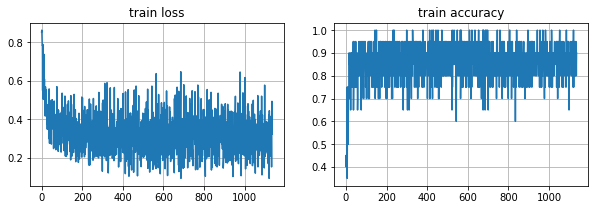

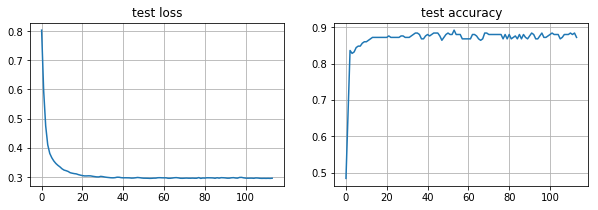

In [7]:
mlutils.plot_hists(train_hist, test_hist)

**observa esto en tensorboard!!!!**

### 4. Predicción

In [13]:
def predict(X_data, nparams):
    def predict_input_iterator():
        d1 = tf.data.Dataset.from_tensor_slices((tf.constant(X_data, dtype=tf.float32), 
                                                 tf.constant(np.ones((len(X_data))), dtype=tf.float32)))
        d1 = d1.repeat(1)
        d1 = d1.batch(len(X_data))
        [next_X, next_y] = d1.make_one_shot_iterator().get_next()
        return next_X, next_y

    tf.reset_default_graph()
    _, prediction, _, _, params, _ = logreg_model(train_input_iterator=predict_input_iterator)
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        preds = sess.run(prediction, feed_dict= {i:j for i,j in zip(params, nparams[0])})[:,0]
    return preds.astype(int)

accuracy 0.86


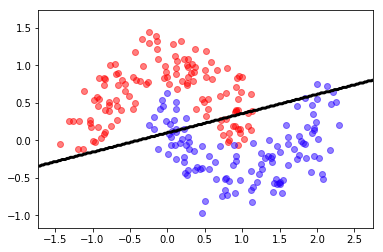

In [14]:
preds = predict(X_test, nparams)
print "accuracy", np.mean(preds==y_test)
mlutils.plot_2D_boundary(lambda X: predict(X, nparams), np.min(X_test, axis=0), np.max(X_test, axis=0))
mlutils.plot_2Ddata(X_test,y_test)

## 5. Usamos `tf.Dataset` y `tf.feature_columns` para crear nuevas columnas

observa cómo:

- creamos una función para generar las funciones de `input` (train, test, predict) de forma que todas tengan el mismo procesado.
- usamos `tf.feature_column` para crear nuevas columnas



In [15]:

def get_dataset(X_data, y_data, repeat, batch_size, shuffle=True):
    d1 = tf.data.Dataset.from_tensor_slices((tf.constant(X_data, dtype=tf.float32), 
                                             tf.constant(y_data.reshape(-1,1), dtype=tf.float32)))
    if shuffle:
        d1 = d1.shuffle(buffer_size=200)
    d1 = d1.repeat(repeat)
    d1 = d1.map(lambda X,y: ({"x0": X[0], "x1": X[1]} ,y))
    d1 = d1.batch(batch_size)    
    return d1


def get_features_defs():
    c1 = tf.feature_column.numeric_column("x0")
    c2 = tf.feature_column.numeric_column("x1")
    bc1 = tf.feature_column.bucketized_column(source_column = c1,boundaries = list(np.linspace(-2,2,10)))
    bc2 = tf.feature_column.bucketized_column(source_column = c2,boundaries = list(np.linspace(-2,2,10)))
    return [bc1, bc2]
    
def make_data_iterator(X_data, y_data, repeat, batch_size, shuffle=True):
    dataset      = get_dataset(X_data, y_data, repeat, batch_size, shuffle)
    feature_defs = get_features_defs()
   
    next_X, next_y = dataset.make_one_shot_iterator().get_next()    
    next_X = tf.feature_column.input_layer(next_X, feature_defs)
    
    return next_X, next_y



train_input_iterator  = lambda: make_data_iterator(X_train, y_train, repeat=500, batch_size=50)
test_input_iterator   = lambda: make_data_iterator(X_test, y_test, repeat=-1, batch_size=len(X_test))


In [16]:

X_data,y_data = make_moons(500, noise=.2)

X_train, y_train = X_data[:split_pos], y_data[:split_pos]
X_test,  y_test  = X_data[split_pos:], y_data[split_pos:]

observa cómo se convierten los datos. ¿Cuál es la **dimensionalidad** de la entrada a nuestro modelo lineal?

In [17]:
probe_data_iterator = lambda: make_data_iterator(X_train, y_train, repeat=1, batch_size=3, shuffle=False)
tx,_ = probe_data_iterator()

with tf.Session() as sess:
    nx = sess.run(tx)

In [18]:
print nx

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [19]:
print X_train[:3]

[[ 0.87081047 -0.42594826]
 [ 1.67030148 -0.12647831]
 [ 1.33486053 -0.85526263]]


ahora ya realizamos nuestro proceso **como anteriormente**

In [20]:
tf.reset_default_graph()

y_hat, prediction, accuracy, loss, params, test_mode = logreg_model(train_input_iterator=train_input_iterator, \
                                                                    test_input_iterator=test_input_iterator)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=.1).minimize(loss)
train_hist, test_hist, nparams = optimize(optimizer, loss, accuracy, params, test_mode, name="bmoons")

step       2400  train_acc 0.98 test_acc 0.93                                                                                 
finished iteration


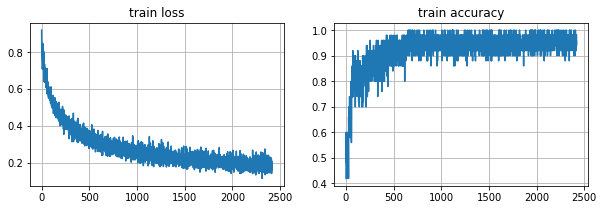

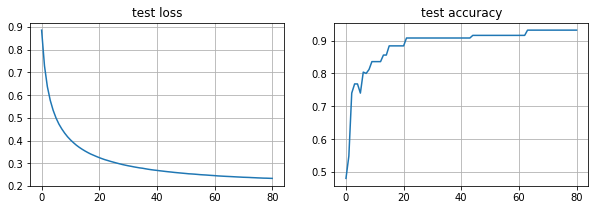

In [21]:
mlutils.plot_hists(train_hist, test_hist)

**observa esto en tensorboard!!!**

In [23]:
def predict(X_new, nparams):
    
    predict_input_iterator = lambda: make_data_iterator(X_new.copy(), np.ones((len(X_new))), 
                                                  repeat=1, batch_size=len(X_new),
                                                  shuffle=False)    
    tf.reset_default_graph()
    _, prediction, _, _, params, _ = logreg_model(train_input_iterator=predict_input_iterator)
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        preds = sess.run(prediction, feed_dict= {i:j for i,j in zip(params, nparams[0])})[:,0]
    return preds.astype(int)

accuracy 0.932


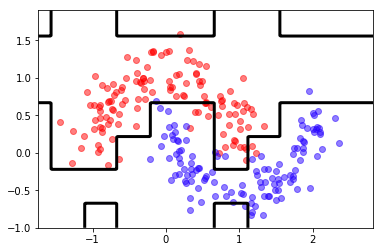

In [24]:
preds = predict(X_test, nparams)
print "accuracy", np.mean(preds==y_test)
mlutils.plot_2D_boundary(lambda X: predict(X, nparams), np.min(X_test, axis=0), np.max(X_test, axis=0))
mlutils.plot_2Ddata(X_test,y_test)